In [1]:
import pandas as pd
from pathlib import Path

# visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

## Read files from OSF

In [2]:
url_excluded_abstract = "https://osf.io/3grcz/download"
url_excluded_full_text = "https://osf.io/puwrd/download"
url_included = "https://osf.io/vuyhq/download"

In [3]:
df_excluded_abstract = pd.read_csv(url_excluded_abstract, usecols=lambda column: column not in ["Unnamed: 14"])
df_excluded_full_text = pd.read_csv(url_excluded_full_text, usecols=lambda column: column not in ["Unnamed: 14"])
df_included = pd.read_csv(url_included)

## Clean datasets

In [4]:
# add labels
df_included["label_included"] = 1
df_included["label_abstract_screening"] = 1

df_excluded_full_text["label_included"] = 0
df_excluded_full_text["label_abstract_screening"] = 1

df_excluded_abstract["label_included"] = 0
df_excluded_abstract["label_abstract_screening"] = 0

In [5]:
# merge datasets
df_merged = df_included.append(df_excluded_full_text, sort=False).append(df_excluded_abstract, sort=False)
df_merged.rename(columns={"Published Year":"year"}, inplace=True)
df_merged.columns = map(str.lower, df_merged.columns)

In [6]:
# remove duplicates
df_title = df_merged["title"].str.replace("[^A-Za-z0-9]", "", regex=True)
df_merged = df_merged[(~df_title.str.lower().duplicated()) | (df_title.isnull())]

## Export datasets

In [7]:
Path("output").mkdir(parents=True, exist_ok=True)
df_merged.to_csv("output/van_Dis_2020.csv", index=False)

## Datasets statistics

In [8]:
n = len(df_merged)
n_inc = df_merged["label_included"].sum()
n_inc_abs = df_merged["label_abstract_screening"].sum()
n_exc = n - n_inc
n_exc_abs = n - n_inc_abs
n_exc_full = n_inc_abs - n_inc

print("Number of papers with missing title:        ", df_merged["title"].isna().sum(), "\n")
print("Number of papers with missing abstract:     ", df_merged["abstract"].isna().sum(), "\n")
print("Total number of papers:                     ", n, "\n")
print("Total number of EXCLUSIONS:                 ", n_exc, "\n")
print("Total EXCLUSIONS after abstract screening:  ", n_exc_abs, "\n")
print("Total INCLUSIONS after abstract screening:  ", n_inc_abs, "\n")
print("Total EXCLUSIONS after full text screening: ", n_exc_full, "\n")
print("Total INCLUSIONS after full text screening: ", n_inc, " (", round(100*n_inc/n, 2), "% )\n")

Number of papers with missing title:         0 

Number of papers with missing abstract:      428 

Total number of papers:                      10288 

Total number of EXCLUSIONS:                  10216 

Total EXCLUSIONS after abstract screening:   9578 

Total INCLUSIONS after abstract screening:   710 

Total EXCLUSIONS after full text screening:  638 

Total INCLUSIONS after full text screening:  72  ( 0.7 % )



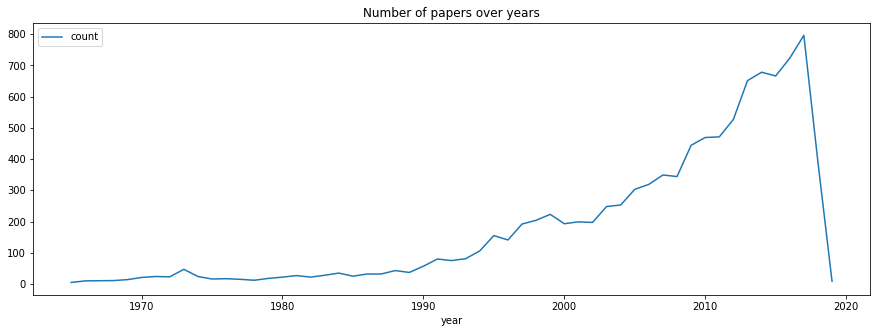

In [9]:
# number of papers over years
df_merged.groupby("year").size().reset_index(name="count").set_index("year").plot(figsize=(15,5))
plt.title("Number of papers over years")
plt.show()

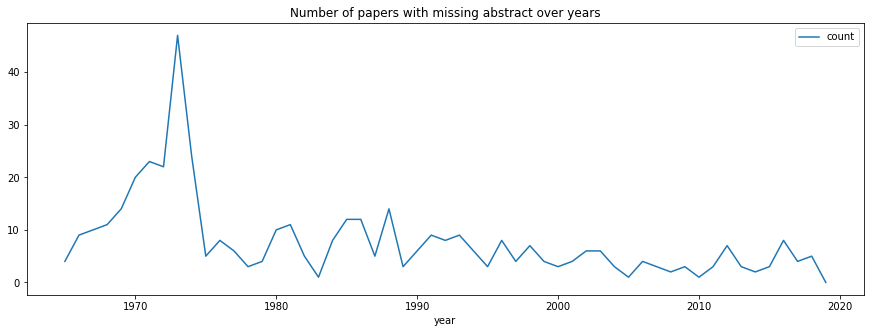

In [10]:
# missing abstract over years
df_merged["abstract"].isna().groupby(df_merged["year"]).sum().astype(int).\
reset_index(name="count").set_index("year").\
plot(figsize=(15,5))
plt.title("Number of papers with missing abstract over years")
plt.show()

There are 1153587 words in the combination of all titles. 

There are 14983826 words in the combination of all abstracts. 



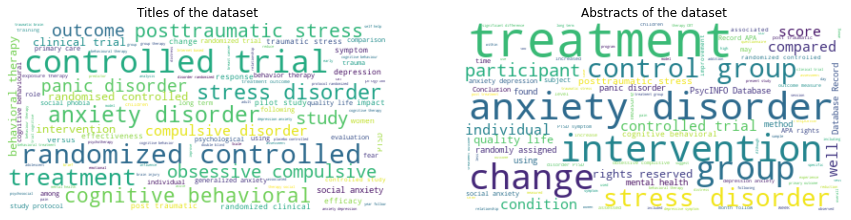

In [11]:
# word cloud for titles and abstracts
# create stopword list
stopwords = set(STOPWORDS)
stopwords.update(["patient", "patients", "effect", "effects", "result", "results"])

# create word cloud text
title_text = " ".join(word for word in df_merged.title.dropna())
abstract_text = " ".join(word for word in df_merged.abstract.dropna())
print("There are {} words in the combination of all titles.".format(len(title_text)), "\n")
print("There are {} words in the combination of all abstracts.".format(len(abstract_text)), "\n")

# generate word cloud images
title_wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(title_text)
abstract_wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(abstract_text)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[15, 15])
ax1.imshow(title_wordcloud, interpolation="bilinear")
ax1.set_title("Titles of the dataset")
ax1.axis("off")
ax2.imshow(abstract_wordcloud, interpolation="bilinear")
ax2.set_title("Abstracts of the dataset")
ax2.axis("off")
plt.show()